# VM和DA FFT分析筆記本 (dB + 對數頻率)

這是一個用於學習VM和DA信號FFT分析的互動式筆記本。
VM和DA共用相同的通道選擇和數據區間，方便比較分析。
**特色：頻譜幅度以dB表示，頻率軸為對數尺度**

## 學習目標
1. 理解VM（電壓）和DA（電流）信號的差異
2. 學習如何同時分析兩種信號
3. 比較VM和DA的頻譜特徵（dB尺度）
4. 觀察時域和頻域的關係

## 第一步：載入必要的套件

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import os
import re

# 設定matplotlib顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成！")

套件載入完成！


## 第二步：設定基本參數

在這裡您可以輕鬆調整所有參數（VM和DA共用）：

In [138]:
# ===== 基本設定 =====
# 相對路徑 (請根據您的檔案位置調整)
csv_file = "01Data/02Processed_csv/0717_new_inner/1000.csv"

# 採樣頻率 (Hz)
sampling_freq = 100000

# 資料選擇參數 (VM和DA共用)
start_index = 275000          # 起始索引
num_samples = 60000      # 要分析的樣本數 (None表示全部)
channel = 2              # 通道編號 (0-5) - VM和DA共用相同通道

# FFT參數 (VM和DA共用)
fft_points = None        # FFT點數 (None表示使用信號長度)
window_type = 'none'     # 視窗類型: 'none', 'hann', 'hamming'

# 頻譜顯示參數
freq_min = 1             # 最小頻率 (Hz) - 對數軸起始點
freq_max = 10000         # 最大頻率 (Hz) - 對數軸結束點
db_min = -100            # 最小dB值
db_max = 100              # 最大dB值

print("參數設定完成！")
print(f"檔案: {csv_file}")
print(f"採樣頻率: {sampling_freq} Hz")
print(f"起始索引: {start_index}")
print(f"樣本數: {num_samples}")
print(f"通道: {channel} (VM和DA共用)")
print(f"FFT點數: {fft_points}")
print(f"視窗類型: {window_type}")
print(f"頻率範圍: {freq_min} - {freq_max} Hz (對數軸)")
print(f"dB範圍: {db_min} - {db_max} dB")

參數設定完成！
檔案: 01Data/02Processed_csv/0717_new_inner/1000.csv
採樣頻率: 100000 Hz
起始索引: 275000
樣本數: 60000
通道: 2 (VM和DA共用)
FFT點數: None
視窗類型: none
頻率範圍: 1 - 10000 Hz (對數軸)
dB範圍: -100 - 100 dB


## 第三步：讀取CSV資料 & 選擇VM和DA通道資料

In [139]:
# 檢查檔案是否存在
if not os.path.exists(csv_file):
    print(f"錯誤: 檔案不存在 {csv_file}")
else:
    # 讀取CSV檔案
    print(f"正在讀取檔案: {csv_file}")
    df = pd.read_csv(csv_file)
    print(f"檔案總長度: {len(df)} 筆資料")
    
    # 找出VM和DA通道
    vm_columns = [col for col in df.columns if col.startswith('vm_')]
    da_columns = [col for col in df.columns if col.startswith('da_')]
    print(f"\nVM通道: {vm_columns}")
    print(f"DA通道: {da_columns}")
    
    # 選擇資料區段
    if num_samples is None:
        num_samples = len(df) - start_index
    
    end_index = min(start_index + num_samples, len(df))
    data_subset = df.iloc[start_index:end_index].copy()
    
    print(f"\n選擇的資料區段:")
    print(f"  索引範圍: {start_index} 到 {end_index-1}")
    print(f"  實際長度: {len(data_subset)} 筆資料")
    print(f"  時間長度: {len(data_subset) / sampling_freq:.3f} 秒")
    
    # 選擇VM通道資料
    if channel >= len(vm_columns):
        print(f"錯誤: VM通道 {channel} 不存在，可用通道: 0-{len(vm_columns)-1}")
    else:
        vm_selected_column = vm_columns[channel]
        vm_signal_data = data_subset[vm_selected_column].values
        
        print(f"\nVM通道 {channel} ({vm_selected_column}):")
        print(f"  資料範圍: {np.min(vm_signal_data):.6f} 到 {np.max(vm_signal_data):.6f} V")
        print(f"  平均值: {np.mean(vm_signal_data):.6f} V")
        print(f"  標準差: {np.std(vm_signal_data):.6f} V")
    
    # 選擇DA通道資料
    if channel >= len(da_columns):
        print(f"錯誤: DA通道 {channel} 不存在，可用通道: 0-{len(da_columns)-1}")
    else:
        da_selected_column = da_columns[channel]
        da_signal_data = data_subset[da_selected_column].values
        
        print(f"\nDA通道 {channel} ({da_selected_column}):")
        print(f"  資料範圍: {np.min(da_signal_data):.0f} 到 {np.max(da_signal_data):.0f} (raw)")
        print(f"  平均值: {np.mean(da_signal_data):.2f} (raw)")
        print(f"  標準差: {np.std(da_signal_data):.2f} (raw)")
        
        # 將DA數據轉換為電流
        # DA conversion parameters
        da_max = 65535  # 16bit maximum value
        voltage_range = 10  # ±5V = 10V total range
        current_ratio = 0.2  # Voltage to current conversion ratio (A/V)
        
        # Conversion: DA value -> voltage -> current
        da_voltage = (da_signal_data / da_max - 0.5) * voltage_range
        da_current = da_voltage * current_ratio
        
        print(f"  電流範圍: {np.min(da_current):.6f} 到 {np.max(da_current):.6f} A")
        print(f"  電流平均值: {np.mean(da_current):.6f} A")
        print(f"  電流標準差: {np.std(da_current):.6f} A")

正在讀取檔案: 01Data/02Processed_csv/0717_new_inner/1000.csv
檔案總長度: 1390000 筆資料

VM通道: ['vm_0', 'vm_1', 'vm_2', 'vm_3', 'vm_4', 'vm_5']
DA通道: ['da_0', 'da_1', 'da_2', 'da_3', 'da_4', 'da_5']

選擇的資料區段:
  索引範圍: 275000 到 334999
  實際長度: 60000 筆資料
  時間長度: 0.600 秒

VM通道 2 (vm_2):
  資料範圍: -0.539934 到 0.542137 V
  平均值: 0.000034 V
  標準差: 0.389868 V

DA通道 2 (da_2):
  資料範圍: 13887 到 49746 (raw)
  平均值: 31787.77 (raw)
  標準差: 13064.93 (raw)
  電流範圍: -0.576196 到 0.518151 A
  電流平均值: -0.029900 A
  電流標準差: 0.398716 A


## 第四步：繪製VM和DA時域信號

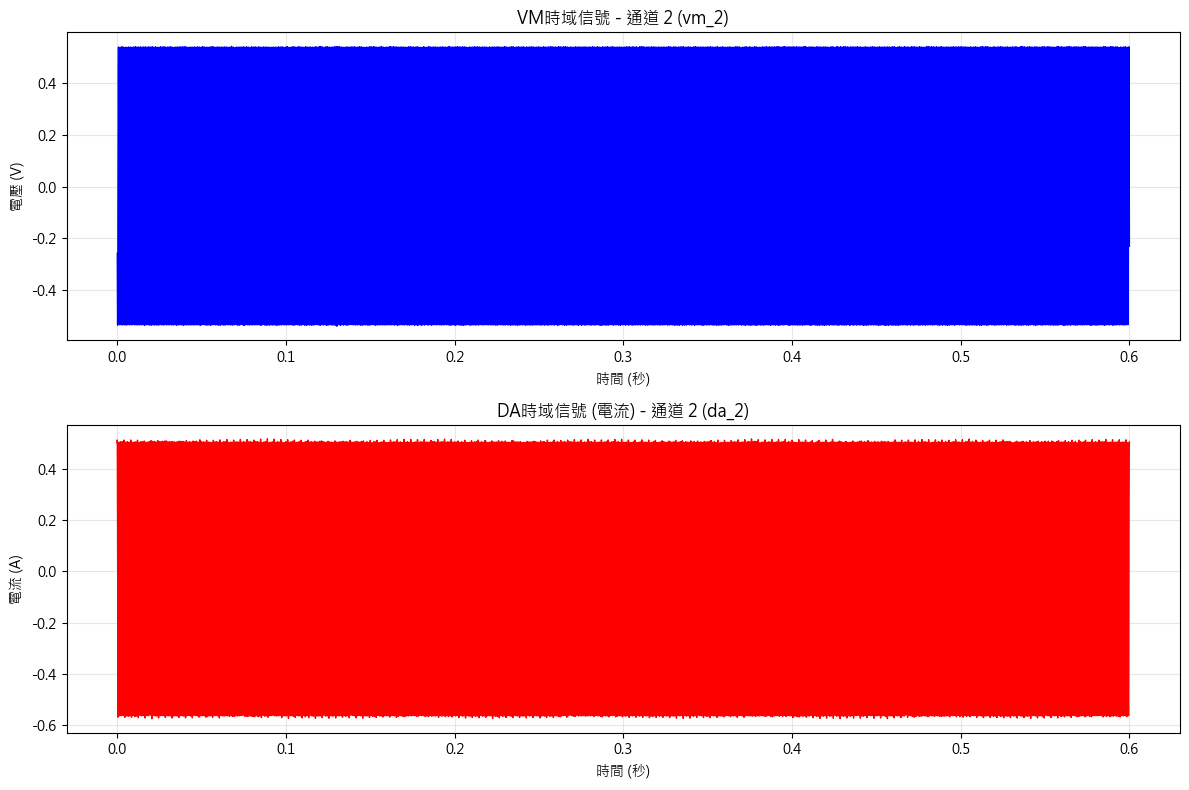

In [140]:
# 繪製VM和DA的時域信號
time_axis = np.arange(len(vm_signal_data)) / sampling_freq

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# VM時域信號
ax1.plot(time_axis, vm_signal_data, 'b-', linewidth=1)
ax1.set_title(f'VM時域信號 - 通道 {channel} ({vm_selected_column})')
ax1.set_xlabel('時間 (秒)')
ax1.set_ylabel('電壓 (V)')
ax1.grid(True, alpha=0.3)

# DA時域信號 (電流)
ax2.plot(time_axis, da_current, 'r-', linewidth=1)
ax2.set_title(f'DA時域信號 (電流) - 通道 {channel} ({da_selected_column})')
ax2.set_xlabel('時間 (秒)')
ax2.set_ylabel('電流 (A)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 第五步：計算VM和DA的FFT

In [141]:
# 定義FFT計算函數
def compute_fft_analysis(signal_data, signal_name):
    """計算FFT分析"""
    print(f"\n=== {signal_name} FFT分析 ===")
    print(f"信號長度: {len(signal_data)} 點")
    
    # 選擇FFT點數
    if fft_points is None:
        current_fft_points = len(signal_data)
    else:
        current_fft_points = fft_points
    
    print(f"FFT點數: {current_fft_points}")
    
    # 準備信號資料
    if len(signal_data) < current_fft_points:
        padded_signal = np.pad(signal_data, (0, current_fft_points - len(signal_data)), 'constant')
        print(f"信號補零到 {current_fft_points} 點")
    else:
        padded_signal = signal_data[:current_fft_points]
        print(f"信號截取到 {current_fft_points} 點")
    
    # 移除DC成分
    signal_no_dc = padded_signal - np.mean(padded_signal)
    
    # 應用視窗函數
    if window_type == 'hann':
        window = np.hanning(len(signal_no_dc))
        signal_windowed = signal_no_dc * window
        print("使用Hanning視窗")
    elif window_type == 'hamming':
        window = np.hamming(len(signal_no_dc))
        signal_windowed = signal_no_dc * window
        print("使用Hamming視窗")
    else:
        signal_windowed = signal_no_dc
        print("不使用視窗函數")
    
    # 計算FFT
    fft_result = fft(signal_windowed)
    frequencies = fftfreq(len(signal_windowed), 1/sampling_freq)
    
    # 只取正頻率部分
    positive_freq_mask = frequencies >= 0
    frequencies = frequencies[positive_freq_mask]
    magnitude_spectrum = np.abs(fft_result[positive_freq_mask])
    
    # 轉換為dB
    # 避免log(0)的問題，加上很小的數值
    magnitude_db = 20 * np.log10(magnitude_spectrum + 1e-12)
    
    print(f"FFT結果:")
    print(f"  頻率範圍: 0 到 {frequencies[-1]:.1f} Hz")
    print(f"  頻率解析度: {frequencies[1] - frequencies[0]:.2f} Hz")
    print(f"  最大幅度: {np.max(magnitude_spectrum):.6f} ({np.max(magnitude_db):.2f} dB)")
    print(f"  平均幅度: {np.mean(magnitude_spectrum):.6f} ({np.mean(magnitude_db):.2f} dB)")
    
    return frequencies, magnitude_spectrum, magnitude_db

# 計算VM的FFT
vm_frequencies, vm_magnitude_spectrum, vm_magnitude_db = compute_fft_analysis(vm_signal_data, "VM")

# 計算DA的FFT
da_frequencies, da_magnitude_spectrum, da_magnitude_db = compute_fft_analysis(da_current, "DA")


=== VM FFT分析 ===
信號長度: 60000 點
FFT點數: 60000
信號截取到 60000 點
不使用視窗函數
FFT結果:
  頻率範圍: 0 到 49998.3 Hz
  頻率解析度: 1.67 Hz
  最大幅度: 16504.460565 (84.35 dB)
  平均幅度: 0.987611 (-14.81 dB)

=== DA FFT分析 ===
信號長度: 60000 點
FFT點數: 60000
信號截取到 60000 點
不使用視窗函數
FFT結果:
  頻率範圍: 0 到 49998.3 Hz
  頻率解析度: 1.67 Hz
  最大幅度: 16885.224502 (84.55 dB)
  平均幅度: 1.109604 (-10.32 dB)


## 第六步：繪製VM和DA的FFT結果 (dB + 對數頻率)

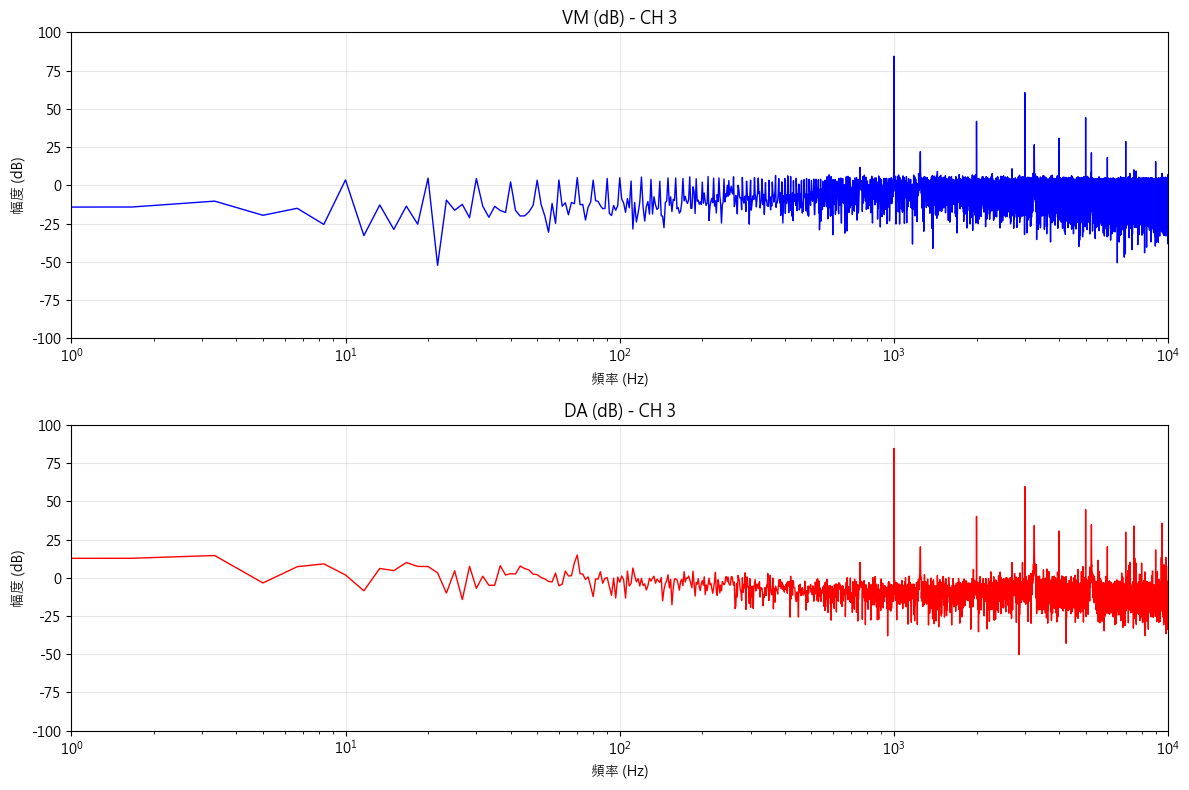


=== VM主要頻率成分 (前10名) ===
   1. 1000.0 Hz ( 84.35 dB, 線性: 16504.460565)
   2. 3000.0 Hz ( 60.57 dB, 線性: 1067.393166)
   3. 5000.0 Hz ( 44.27 dB, 線性: 163.534700)
   4. 2000.0 Hz ( 41.83 dB, 線性: 123.413503)
   5. 4000.0 Hz ( 30.73 dB, 線性: 34.380184)
   6. 7000.0 Hz ( 28.60 dB, 線性: 26.910011)
   7. 3248.3 Hz ( 26.52 dB, 線性: 21.184151)
   8. 3246.7 Hz ( 25.40 dB, 線性: 18.629172)
   9. 1248.3 Hz ( 22.03 dB, 線性: 12.630213)
  10. 5248.3 Hz ( 21.24 dB, 線性: 11.528707)

=== DA主要頻率成分 (前10名) ===
   1. 1000.0 Hz ( 84.55 dB, 線性: 16885.224502)
   2. 3000.0 Hz ( 59.61 dB, 線性: 956.225837)
   3. 5000.0 Hz ( 44.57 dB, 線性: 169.263330)
   4. 2000.0 Hz ( 40.14 dB, 線性: 101.572483)
   5. 9495.0 Hz ( 35.67 dB, 線性: 60.754755)
   6. 17990.0 Hz ( 35.22 dB, 線性: 57.673945)
   7. 5248.3 Hz ( 34.69 dB, 線性: 54.253351)
   8. 3248.3 Hz ( 34.17 dB, 線性: 51.116236)
   9. 15990.0 Hz ( 34.15 dB, 線性: 51.017502)
  10. 22238.3 Hz ( 34.00 dB, 線性: 50.143111)


In [142]:
# 繪製VM和DA的頻譜 (dB + 對數頻率)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# VM頻譜 (dB + 對數頻率)
ax1.semilogx(vm_frequencies, vm_magnitude_db, 'b-', linewidth=1)
ax1.set_title(f'VM (dB) - CH {channel+1}')
ax1.set_xlabel('頻率 (Hz)')
ax1.set_ylabel('幅度 (dB)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(freq_min, freq_max)
ax1.set_ylim(db_min, db_max)

# DA頻譜 (dB + 對數頻率)
ax2.semilogx(da_frequencies, da_magnitude_db, 'r-', linewidth=1)
ax2.set_title(f'DA (dB) - CH {channel+1}')
ax2.set_xlabel('頻率 (Hz)')
ax2.set_ylabel('幅度 (dB)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(freq_min, freq_max)
ax2.set_ylim(db_min, db_max)

plt.tight_layout()
plt.show()

# 找出主要頻率成分 (dB)
print(f"\n=== VM主要頻率成分 (前10名) ===")
vm_peak_indices = np.argsort(vm_magnitude_db)[-10:]
for i, idx in enumerate(reversed(vm_peak_indices)):
    freq = vm_frequencies[idx]
    mag_db = vm_magnitude_db[idx]
    mag_linear = vm_magnitude_spectrum[idx]
    print(f"  {i+1:2d}. {freq:6.1f} Hz ({mag_db:6.2f} dB, 線性: {mag_linear:.6f})")

print(f"\n=== DA主要頻率成分 (前10名) ===")
da_peak_indices = np.argsort(da_magnitude_db)[-10:]
for i, idx in enumerate(reversed(da_peak_indices)):
    freq = da_frequencies[idx]
    mag_db = da_magnitude_db[idx]
    mag_linear = da_magnitude_spectrum[idx]
    print(f"  {i+1:2d}. {freq:6.1f} Hz ({mag_db:6.2f} dB, 線性: {mag_linear:.6f})")

## 第七步：VM和DA頻譜比較 (dB + 對數頻率)

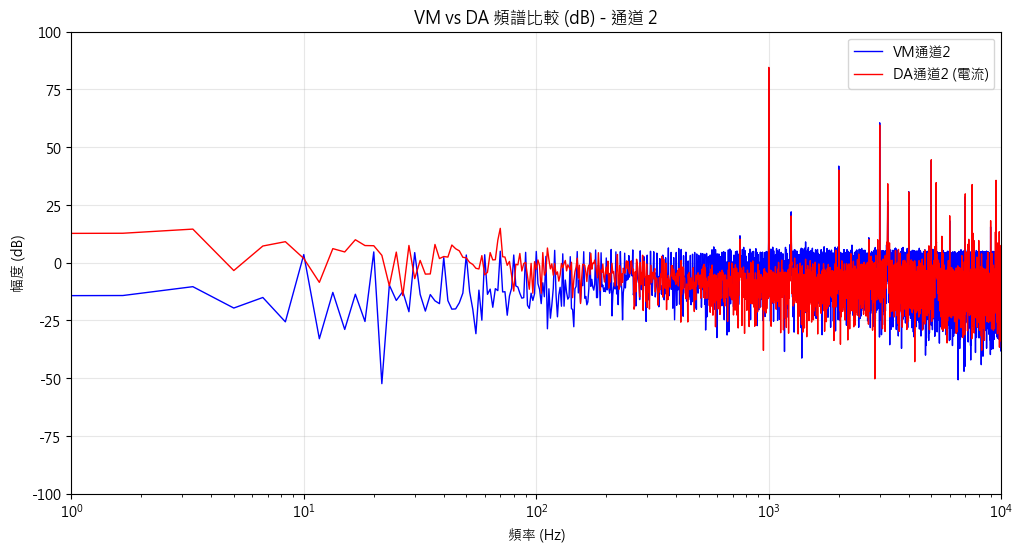


VM和DA頻譜相關係數 (dB): 0.6485
  → VM和DA頻譜中等相關

頻譜差異統計 (VM - DA):
  平均差異: -10.29 dB
  標準差: 12.28 dB
  最大差異: 31.01 dB
  最小差異: -52.96 dB


In [143]:
# 在同一圖表中比較VM和DA的頻譜 (dB + 對數頻率)
plt.figure(figsize=(12, 6))

# 繪製VM和DA頻譜
plt.semilogx(vm_frequencies, vm_magnitude_db, 'b-', linewidth=1, label=f'VM通道{channel}')
plt.semilogx(da_frequencies, da_magnitude_db, 'r-', linewidth=1, label=f'DA通道{channel} (電流)')

plt.title(f'VM vs DA 頻譜比較 (dB) - 通道 {channel}')
plt.xlabel('頻率 (Hz)')
plt.ylabel('幅度 (dB)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(freq_min, freq_max)
plt.ylim(db_min, db_max)
plt.show()

# 計算頻譜相關性 (dB)
# 將兩個頻譜插值到相同的頻率網格進行比較
common_freq = np.logspace(np.log10(freq_min), np.log10(freq_max), 1000)

vm_interp = np.interp(common_freq, vm_frequencies, vm_magnitude_db)
da_interp = np.interp(common_freq, da_frequencies, da_magnitude_db)

# 計算相關係數
correlation = np.corrcoef(vm_interp, da_interp)[0, 1]
print(f"\nVM和DA頻譜相關係數 (dB): {correlation:.4f}")

if correlation > 0.7:
    print("  → VM和DA頻譜高度相關")
elif correlation > 0.3:
    print("  → VM和DA頻譜中等相關")
else:
    print("  → VM和DA頻譜低度相關")

# 計算頻譜差異統計
spectrum_diff = vm_interp - da_interp
print(f"\n頻譜差異統計 (VM - DA):")
print(f"  平均差異: {np.mean(spectrum_diff):.2f} dB")
print(f"  標準差: {np.std(spectrum_diff):.2f} dB")
print(f"  最大差異: {np.max(spectrum_diff):.2f} dB")
print(f"  最小差異: {np.min(spectrum_diff):.2f} dB")

## 第八步：完整的時域和頻域對比 (dB + 對數頻率)

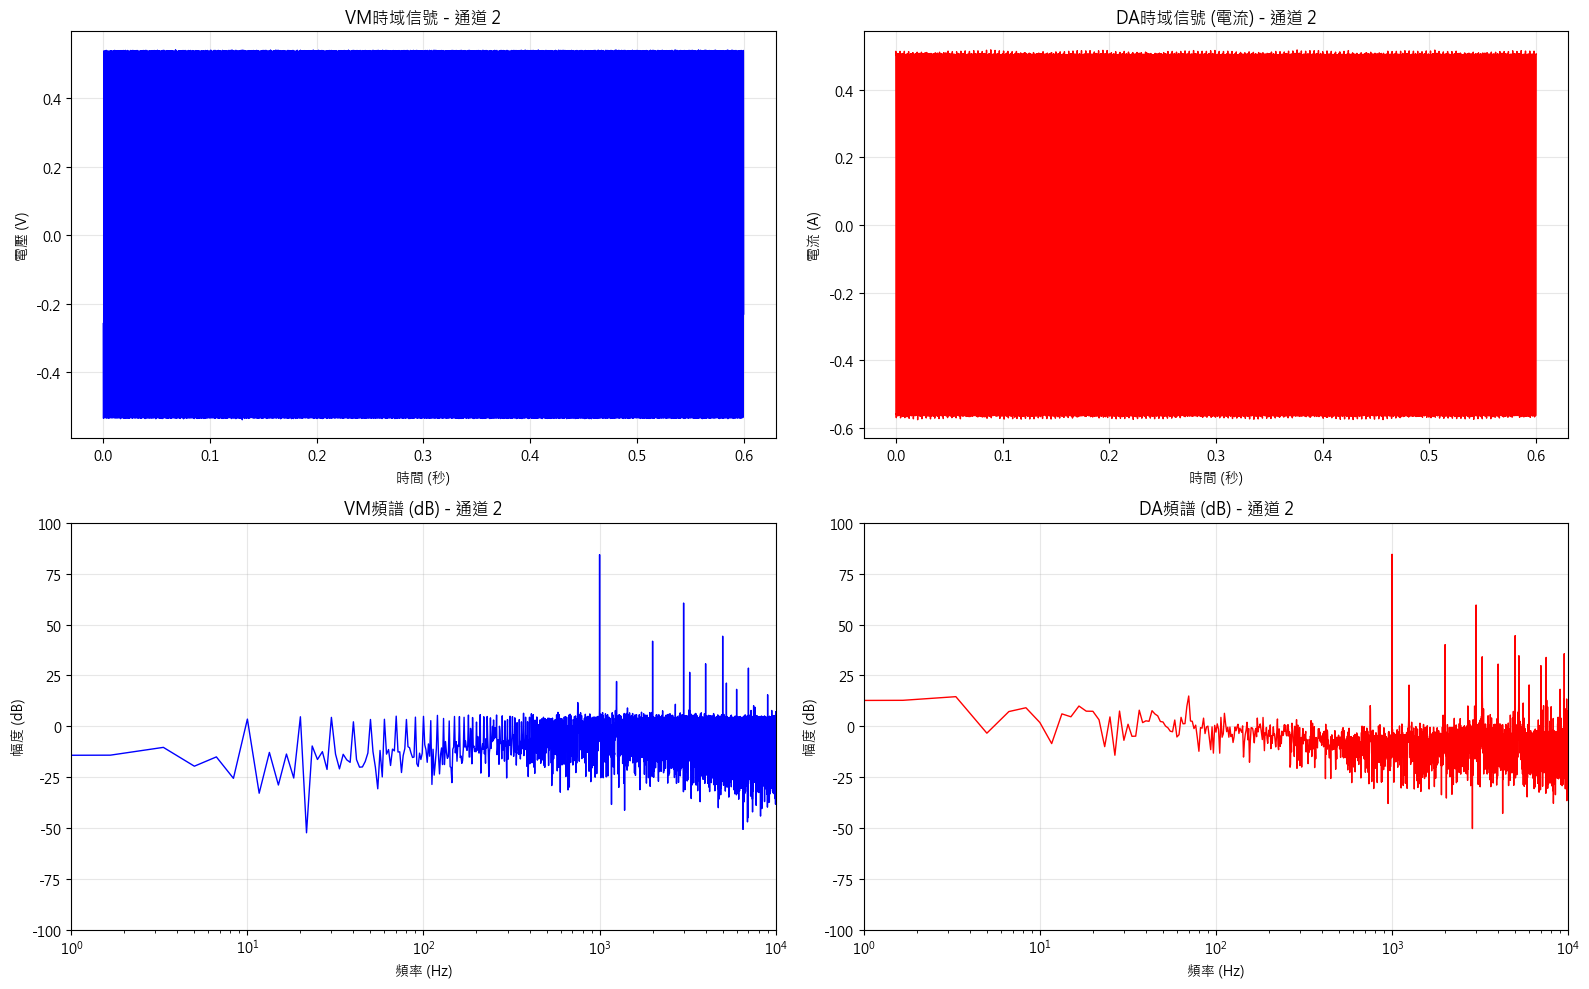

In [144]:
# 完整的時域和頻域對比 (dB + 對數頻率)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# VM時域
ax1.plot(time_axis, vm_signal_data, 'b-', linewidth=1)
ax1.set_title(f'VM時域信號 - 通道 {channel}')
ax1.set_xlabel('時間 (秒)')
ax1.set_ylabel('電壓 (V)')
ax1.grid(True, alpha=0.3)

# DA時域
ax2.plot(time_axis, da_current, 'r-', linewidth=1)
ax2.set_title(f'DA時域信號 (電流) - 通道 {channel}')
ax2.set_xlabel('時間 (秒)')
ax2.set_ylabel('電流 (A)')
ax2.grid(True, alpha=0.3)

# VM頻域 (dB + 對數頻率)
ax3.semilogx(vm_frequencies, vm_magnitude_db, 'b-', linewidth=1)
ax3.set_title(f'VM頻譜 (dB) - 通道 {channel}')
ax3.set_xlabel('頻率 (Hz)')
ax3.set_ylabel('幅度 (dB)')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(freq_min, freq_max)
ax3.set_ylim(db_min, db_max)

# DA頻域 (dB + 對數頻率)
ax4.semilogx(da_frequencies, da_magnitude_db, 'r-', linewidth=1)
ax4.set_title(f'DA頻譜 (dB) - 通道 {channel}')
ax4.set_xlabel('頻率 (Hz)')
ax4.set_ylabel('幅度 (dB)')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(freq_min, freq_max)
ax4.set_ylim(db_min, db_max)

plt.tight_layout()
plt.show()

## 第九步：頻譜差異分析

<Figure size 1200x800 with 0 Axes>

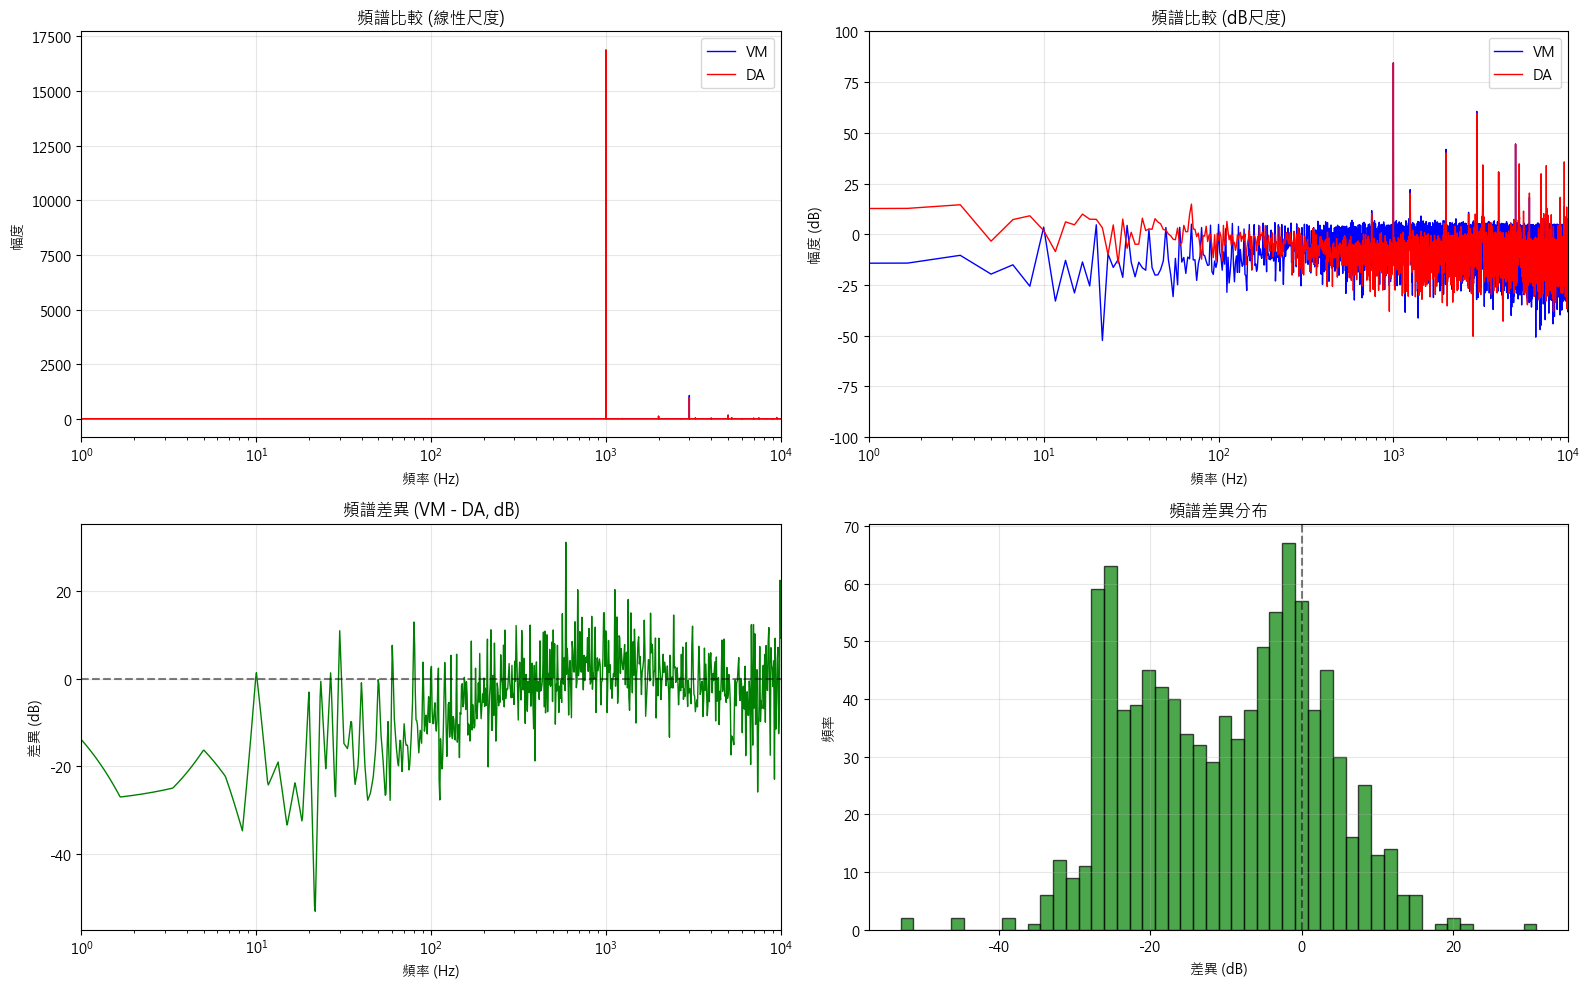


=== 頻譜差異統計分析 ===
平均差異: -10.29 dB
中位數差異: -9.44 dB
標準差: 12.28 dB
最大差異: 31.01 dB
最小差異: -52.96 dB
差異範圍: 83.97 dB

最大差異頻率點: 21.7 Hz, 差異: -52.96 dB


In [145]:
# 頻譜差異分析
plt.figure(figsize=(12, 8))

# 創建子圖
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

# 1. 頻譜比較 (線性尺度)
ax1.semilogx(vm_frequencies, vm_magnitude_spectrum, 'b-', linewidth=1, label='VM')
ax1.semilogx(da_frequencies, da_magnitude_spectrum, 'r-', linewidth=1, label='DA')
ax1.set_title('頻譜比較 (線性尺度)')
ax1.set_xlabel('頻率 (Hz)')
ax1.set_ylabel('幅度')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(freq_min, freq_max)

# 2. 頻譜比較 (dB尺度)
ax2.semilogx(vm_frequencies, vm_magnitude_db, 'b-', linewidth=1, label='VM')
ax2.semilogx(da_frequencies, da_magnitude_db, 'r-', linewidth=1, label='DA')
ax2.set_title('頻譜比較 (dB尺度)')
ax2.set_xlabel('頻率 (Hz)')
ax2.set_ylabel('幅度 (dB)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(freq_min, freq_max)
ax2.set_ylim(db_min, db_max)

# 3. 頻譜差異 (dB)
common_freq = np.logspace(np.log10(freq_min), np.log10(freq_max), 1000)
vm_interp = np.interp(common_freq, vm_frequencies, vm_magnitude_db)
da_interp = np.interp(common_freq, da_frequencies, da_magnitude_db)
spectrum_diff = vm_interp - da_interp

ax3.semilogx(common_freq, spectrum_diff, 'g-', linewidth=1)
ax3.set_title('頻譜差異 (VM - DA, dB)')
ax3.set_xlabel('頻率 (Hz)')
ax3.set_ylabel('差異 (dB)')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(freq_min, freq_max)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# 4. 頻譜差異直方圖
ax4.hist(spectrum_diff, bins=50, alpha=0.7, color='green', edgecolor='black')
ax4.set_title('頻譜差異分布')
ax4.set_xlabel('差異 (dB)')
ax4.set_ylabel('頻率')
ax4.grid(True, alpha=0.3)
ax4.axvline(x=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 統計分析
print(f"\n=== 頻譜差異統計分析 ===")
print(f"平均差異: {np.mean(spectrum_diff):.2f} dB")
print(f"中位數差異: {np.median(spectrum_diff):.2f} dB")
print(f"標準差: {np.std(spectrum_diff):.2f} dB")
print(f"最大差異: {np.max(spectrum_diff):.2f} dB")
print(f"最小差異: {np.min(spectrum_diff):.2f} dB")
print(f"差異範圍: {np.max(spectrum_diff) - np.min(spectrum_diff):.2f} dB")

# 找出差異最大的頻率點
max_diff_idx = np.argmax(np.abs(spectrum_diff))
max_diff_freq = common_freq[max_diff_idx]
max_diff_value = spectrum_diff[max_diff_idx]
print(f"\n最大差異頻率點: {max_diff_freq:.1f} Hz, 差異: {max_diff_value:.2f} dB")

## 實驗建議

現在您可以回到第二步，調整不同的參數來觀察VM和DA的差異：

1. **調整資料區段** - 改變 `start_index` 和 `num_samples`
2. **調整FFT點數** - 設定 `fft_points = 1024, 2048, 4096, 8192`
3. **嘗試不同視窗函數** - 設定 `window_type = 'none', 'hann', 'hamming'`
4. **比較不同通道** - 改變 `channel = 0, 1, 2, 3, 4, 5`
5. **調整頻率範圍** - 改變 `freq_min` 和 `freq_max`
6. **調整dB範圍** - 改變 `db_min` 和 `db_max`
7. **觀察VM和DA的相關性** - 比較兩個信號的頻譜特徵

### 學習重點：
- **dB表示法**：20*log10(幅度)，便於觀察動態範圍
- **對數頻率軸**：能同時觀察低頻和高頻特徵
- **VM是電壓信號，DA是電流信號**
- **觀察兩個信號在時域和頻域的差異**
- **分析頻譜相關性來理解信號的關係**
- **了解電壓和電流信號的頻譜特徵差異**

### dB的優勢：
- 可以同時觀察很大和很小的信號
- 便於比較不同量級的信號
- 符合人耳聽覺特性（對數響應）
- 在信號處理中廣泛使用